In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from scipy import integrate

plt.style.use('ggplot')
%matplotlib inline
# Plotting colors
red = "#E24A33"
blue = "#348ABD"
purple = "#988ED5"
grey = "#777777"
yellow = "#FBC15E"
green = "#8EBA42"
rose = "#FFB5B8"

On considère un puit de potentiel 1D $V(x)$. L'équation de Schrodinger donne alors:

$$ - \frac{\hbar^2}{2\mu} \frac{d^2\phi(\chi)}{dx^2}+V(\chi)\phi(\chi) = \epsilon \phi(\chi)$$

En utilisant les coordonnées réduites, l'équation différentielle devient:

$$- \frac{d^2\phi(x)}{dx^2} + (V(x) - E)\phi(x)=0, \quad x = \chi\sqrt{\frac{\hbar}{\mu \omega}}, E = \frac{2\epsilon}{\hbar \omega}$$

Pour la résoudre, on utilise la méthode de Numérov. Soit $x_0$, un point où l'on connait $\phi(x_0)$ et $\phi(x_0 + h)$ tel que $h$ soit un nombre très petit. On peut alors
propager la solution $\phi$ en appliquant itérativement l'approximation que:

$$f(x + h) \approx 2 f(x) + h^2f''(x) - f(x -h)$$

Or, à l'aide de l'équation de Schrodinger dans les coordonnées réduites, on obtient finalement que:

$$f(x + h) \approx 2 f(x) + h^2G(x)f(x) - f(x -h) \approx \left( 2 + h^2 \left( V(x) - E\right) \right)f(x) - f(x - h)$$

On implémente alors cet algorithme dans la fonction ```numerov_method``` par propagation en avant. On ajoute également différents potentiels dans les fonctions ```harmonic_potential```, ```perturbated_potential``` et ```perturbated_potential_symetric```.

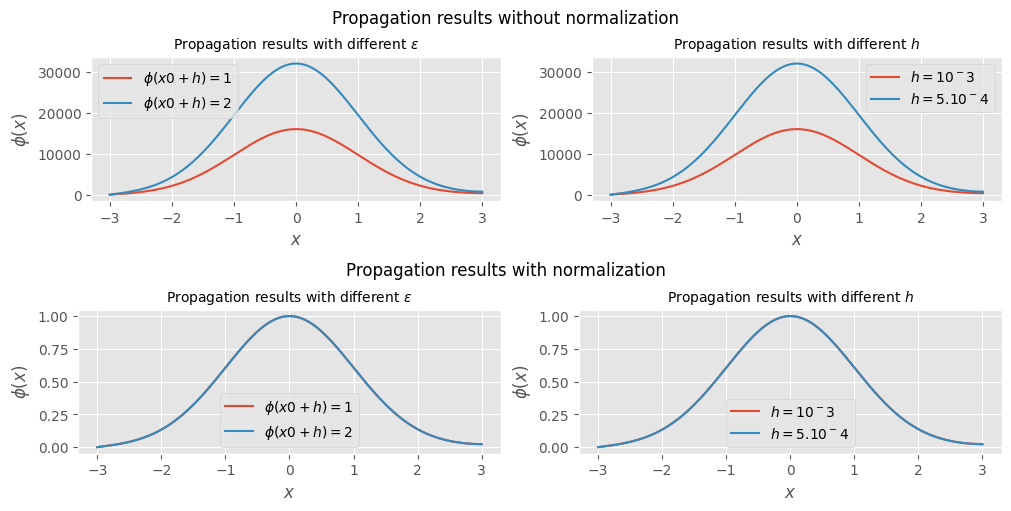

In [2]:
def harmonic_potential(x: float | np.ndarray) -> float | np.ndarray:
    """Returns the harmonic potential V(x) = x²

    Args:
        x (float | np.ndarray): Position where to determine the potential

    Returns:
        float | np.ndarray: The potential at each position given
    """
    return x**2

def perturbated_potential(x: float) -> float| np.ndarray:
    """Returns the perturbated harmonic potential V(x) = x² - 0.1x³

    Args:
        x (float | np.ndarray): Position where to determine the potential

    Returns:
        float | np.ndarray: The potential at each position given
    """
    return x**2 - 0.1 * x**3

def perturbated_potential_symetric(x: float) -> float| np.ndarray:
    """Returns the symetric perturbated harmonic potential V(x) = x² - 0.1|x|³

    Args:
        x (float | np.ndarray): Position where to determine the potential

    Returns:
        float | np.ndarray: The potential at each position given
    """
    return x**2 - 0.1 * np.abs(x)**3

def numerov_method(y0: float, y1: float, x: np.ndarray, potential_function: Callable, energy: float, propagation_step: float = 10**(-3)):
    """Given two close known value of y0 = Ф(x0) and y1 = Ф(x0 + step_size), this function propagates the solution according to the
    3rd order Numerov's method with given parameters. \n
    Only forward propagation is available. \n

    Args:
        y0 (float): Value of Ф(x0) where x0 is the lower bound. \n
        y1 (float): Value of Ф(x0 + step_size) where x0 is the lower bound \n
        x (np.ndarray): Array of coordinates where the function has to solve the equation \n
        potential_function (Callable): Function returning the potential at a given location. \n
        energy (float): Kinetic energy of the particle \n
        propagation_step (float, optional): Gap between two consecutive values of Ф. Defaults to 10**(-3).
    """
    
    def G(x: float) -> float:
        """Translated potential function

        Args:
            x (float): Position

        Returns:
            float: Value of G(x)
        """
        return potential_function(x) - energy
    
    Ф = np.zeros_like(x)
    Ф[0], Ф[1] = y0, y1
    
    for i in range(1, x.shape[0] - 1):
        Ф[i + 1] = (2 + propagation_step**2 * G(x[i])) * Ф[i] - Ф[i - 1]
    
    return Ф

def auto_numerov(y0: float, y1: float, potential_function: Callable, energy: float, propagation_step: float = None):
    """Given two close known value of y0 = Ф(x0) and y1 = Ф(x0 + step_size), this function propagates the solution according to the
    3rd order Numerov's method with given parameters. \n
    Only forward propagation is available. \n
    This function automatically determines the required step_size (unless step_size is given) and interval to perform the propagation. 

    Args:
        y0 (float): Value of Ф(x0) where x0 is the lower bound \n
        y1 (float): Value of Ф(x0 + step_size) where x0 is the lower bound \n
        potential_function (Callable): Function returning the potential at a given location. \n
        energy (float): Kinetic energy of the particle \n
        propagation_step (float): Gap between two consecutive values of Ф. Defaults to None. If None, step_size is automatically inferred  
    """
    propagation_step: float = 2 * np.sqrt(energy) / (5 * energy + 1) if propagation_step is None else propagation_step
    x_start = - (np.sqrt(energy) + 2)
    x_end = - x_start
    
    x = np.arange(x_start, x_end + propagation_step, propagation_step)
    Ф = numerov_method(y0, y1, x, potential_function, energy, propagation_step)
    
    pseudo_normalization(Ф)
    return x, Ф

def normalize(y: np.ndarray, x: np.ndarray) -> None:
    """Normalize a function f(x) such that ∫f(x)dx = 1 over the space 

    Args:
        y (_type_): f(x) 
        x (_type_): x coordinates
    """
    area = integrate.simpson(y, x)
    y /= area
    
def pseudo_normalization(*y: np.ndarray) -> None:
    """Performs in-place a pseudo-normalization such that the absolute maximal value of y = 1

    Args:
        y (np.ndarray): Array of y-coordinates to normalize
    """
    for array in y:
        array /= np.max(np.abs(array))

%matplotlib inline  
# Long code to plot simulation results with and without normalization
if __name__ == "__main__":
    # Parameters
    E = 0.99998
    x_start = - (np.sqrt(E) + 2)
    x_end = - x_start
    h = 10**(-3)
    epsilon_1 = 1
    epsilon_2 = 2

    x = np.arange(x_start, x_end, h)
    x_s = np.arange(x_start, x_end, h / 2)

    # Verification of the behavior of the propagation according to the parameters
    y1 = numerov_method(0, epsilon_1, x, harmonic_potential, E, h)
    y2 = numerov_method(0, epsilon_2, x, harmonic_potential, E, h)

    y3 = numerov_method(0, epsilon_1, x, harmonic_potential, E, h)
    y4 = numerov_method(0, epsilon_1, x_s, harmonic_potential, E, h / 2)


    # Plotting
    fig = plt.figure(constrained_layout=True, figsize=(10, 5))

    subfigs = fig.subfigures(nrows=2, ncols=1)
    subfigs[0].suptitle("Propagation results without normalization")
    subfigs[1].suptitle("Propagation results with normalization")

    (ax1, ax2) = subfigs[0].subplots(nrows=1, ncols=2)
    (ax3, ax4) = subfigs[1].subplots(nrows=1, ncols=2)

    ax1.plot(x, y1, label=f"$\phi(x0 + h) = {epsilon_1}$")
    ax1.plot(x, y2, label=f"$\phi(x0 + h) = {epsilon_2}$")
    ax1.set_xlabel("$x$")
    ax1.set_ylabel("$\phi(x)$")
    ax1.legend(loc="upper left")
    ax1.set_title("Propagation results with different $\epsilon$", fontsize="medium")

    ax2.plot(x, y3, label=f"$h = 10^{-3}$")
    ax2.plot(x_s, y4, label=f"$h = 5.10^{-4}$")
    ax2.set_xlabel("$x$")
    ax2.set_ylabel("$\phi(x)$")
    ax2.legend(loc="upper right")
    ax2.set_title("Propagation results with different $h$", fontsize="medium")

    # Normalization
    pseudo_normalization(y1, y2, y3, y4)

    ax3.plot(x, y1, label=f"$\phi(x0 + h) = {epsilon_1}$")
    ax3.plot(x, y2, label=f"$\phi(x0 + h) = {epsilon_2}$")
    ax3.set_xlabel("$x$")
    ax3.set_ylabel("$\phi(x)$")
    ax3.legend(loc="lower center")
    ax3.set_title("Propagation results with different $\epsilon$", fontsize="medium")

    ax4.plot(x, y3, label=f"$h = 10^{-3}$")
    ax4.plot(x_s, y4, label=f"$h = 5.10^{-4}$")
    ax4.set_xlabel("$x$")
    ax4.set_ylabel("$\phi(x)$")
    ax4.legend(loc="lower center")
    ax4.set_title("Propagation results with different $h$", fontsize="medium")

    plt.show()

On remarque que selon les paramètres $\epsilon$ et $h$ (ou ```step_size``` dans le programme), les valeurs de $\phi(x)$ changent. En réalité, le résultat est identique à un facteur près. Cependant, on sait que le carré de la fonction d'onde doit être normalisé avec:

$$ \int_{-\infty}^{+\infty} |\phi(x)|^2 dx = 1$$

Ainsi, lorsque l'on tracera la densité de probabilité $P(x) = |\phi(x)|^2$, on prendra soin de normaliser cette dernière avec ```normalize```. De plus, nous normaliserons également $\phi(x)$ pour comparer facilement des propagations avec des paramètres différents (notamment valeur de $\phi(x + h)$ et $h$), cependant, selon le niveau d'énergie, l'aire sous la fonction propre peut être nul (cas des fonctions d'ordres pairs), on divisera donc l'ensemble de $\phi_n(x)$ par sa valeur maximale en valeur absolue.

En normalisant $\phi(x)$, les fonctions d'ondes précédentes deviennent alors toutes confondues comme l'on peut le voir au-dessus.

On définit ensuite une fonction ```scipy_odeint``` permettant de résoudre le même problème en utilisant le solveur présent dans scipy. Nous l'utiliserons plus tard pour vérifier l'exactitude de notre implémentation de la méthode de Numerov, mais aussi les limites de cette dernière.

In [3]:
%matplotlib inline
def scipy_odeint(y0: float, y1: float, potential_function: Callable, E: float, propagation_step: float = 10**(-3)) -> tuple[np.ndarray, np.ndarray]:
    """Returns the solution of the schrodinger's equation to solve in a given potential. 

    Args:
        y0 (float): Initial value of Ф(x0) where x0 = x[0]
        y1 (float): Value of Ф(x0 + h) where h = step_size
        x (np.ndarray): Array of coordinates where the function has to solve the equation
        potential_function (Callable): Function returning the potential at a given location.
        E (float): Kinetic energy of the particle
        step_size (float, optional): Gap between two consecutive values of Ф. Defaults to 10**(-3).
    """
    def schrodinger_equation(y: tuple[float, float], x: float, potential_function: Callable, E: float):
        """Returns the first and second derivative of phi

        Args:
            y (tuple[float, float]): Value of Ф(x) and Ф'(x)
            x (float): Coordinates for scipy solver
            potential_function (Callable): Function returning the potential at a given location.
            E (float): Kinetic energy of the particle

        Returns:
            tuple[float, float]: Value of Ф'(x) and Ф''(x)
        """
        phi, dphi = y
        return [dphi, (potential_function(x) - E) * phi]
    
    propagation_step: float = 2 * np.sqrt(E) / (5 * E + 1) if propagation_step is None else propagation_step
    
    x_start = -np.sqrt(E) - 2
    x_end = -x_start
    x = np.arange(x_start, x_end, propagation_step)
    
    inititial_conditions = [y0, y1]
    sol = integrate.odeint(schrodinger_equation, inititial_conditions, x, args=(potential_function, E))
    y = sol[:, 0]
    
    pseudo_normalization(y)
    
    return x, y

Il nous reste enfin à définir une fonction capable de chercher de façon autonome les $n$ premières fonctions d'ondes qui sont physiquement acceptables. Pour cela, nous suivons simplement l'algorithme de minimisation suivant:


# Algorithme de minimisation

-------

-------
 On commence par choisir une valeur d'énergie initiale $E_1$ qu'on sait plus basse que la première énergie acceptable. On calcule la fonction d'onde pour cette énergie avec la fonction ```auto_numerov``` ou ```scipy_odeint```. On calcule ensuite la fonction d'onde pour une énergie $E_2$ supérieur d'un pas p à $E_1$. Nous savons que la fonction d'onde doit tendre vers 0 lorsque x tend vers $+\infty$. On extraie donc les valeurs des fonctions d'ondes pour la valeur de x la plus grande. Si l'énergie de la particule est comprise entre $E_1$ et $E_2$, ces valeurs vont avoir des signes opposées. On calcule donc des fonctions d'ondes avec des énergies $E_3$,$E_4$,etc jusqu'à observer un changement de signe. Nous avons alors un intervalle $[E_i,E_{i+1}]$. On peut répéter nos calculs depuis le début avec $E_i$ comme valeur initiale et un pas plus petit. On répète l'opération jusqu'à avoir la précision voulue.

Un fois le premier niveau d'énergie déterminé, on peut répéter notre algorithme pour une énergie initiale supérieure à celle déterminée avant. 

On implémente alors une fonction ```solve_eigenfunctions``` capable de déterminer les différents niveaux d'énergies accessibles à la particule. Nous prenons soin de faire en sorte que cette fonction puisse autant utiliser ```auto_numerov``` ayant une précision dépendante de l'énergie E ou bien ```numerov_method``` dont on peut manuellement manipuler la précision avec l'intervalle $h$. Nous réaliserons des comparaisons entre ces deux méthodes devant les solutions exactes connues.

Enfin, on en profite pour définir une fonction ```search_nodes``` capable de chercher les noeuds d'une fonction d'onde donnée en retournant les coordonnées de ces derniers.

In [4]:
def get_power(x: float) -> int:
    """Returns the power of ten of any float number.
    
    Example:
        get_power(0.0004) = -4 \n
        get_power(200) = 2 \n

    Args:
        x (float): Number

    Returns:
        int: Power of tenth of x
    """ 
    x: float = np.abs(x)
    power: int = 0
    
    while not 1 <= x < 10:
        if x > 1:
            x //= 10
            power += 1
        if x < 1:
            x *= 10
            power -= 1
            
    return power
       
def search_nodes(y: np.ndarray, x: np.ndarray) -> tuple[list[float], list[float]]:
    """Searches every x such that y(x) = 0

    Args:
        y (np.ndarray): Array containing y-coordinates \n
        x (np.ndarray): Array containing x-coordinates

    Returns:
        tuple[list[float], list[float]]: Coordinates where y(x) = 0
    """
    
    # To avoid taking the first and last 0 in y as a node (which isn't the case)
    test_y = y[1:-1]
    test_x = x[1:-1]
    
    sieve = np.abs(np.diff(np.sign(test_y))).astype(bool)
    x_out = (test_x[:-1][sieve] + test_x[1:][sieve]) / 2
    return x_out, np.zeros_like(x_out)

def solve_eigenfunctions(y0: float, y1: float, potential_function: Callable, Ei: float, precision: float, number_of_eigenfunctions: int, propagation_step: float = None, solver: Callable = auto_numerov) -> np.ndarray:
    """Based on a set of parameters, infers the closest energy level where a physically acceptable eigenfunction exists.

    Args:
        y0 (float): Value of Ф(x0) where x0 is the lower bound \n
        y1 (float): Value of Ф(x0 + step_size) where x0 is the lower bound \n
        potential_function (Callable): Function returning the potential at a given location. \n
        Ei (float): Initial energy guess (should not be too low nor 0, or eigenfunction could be missed) \n
        precision (float): Required precision before returning the result (|f(last_x)| < precision) \n
        number_of_eigenfunctions (int): Number of eigentfunctions that should be found. \n
        propagation_step (float, optional): Gap between two consecutive values of Ф. Defaults to None. If None, propagation step is infered \n
        solver (Callabe): Function to use to propagate the solution (useful to compare different solver).

    Returns:
        np.ndarray: Array containing energy levels
    """
    
    def recursive_search(last_energy: float, last_y: float, precision: float, energy_step: float, propagation_step: float = None) -> float:
        """Recursive search algorithm searching the closest eigenfunction satisfying |f(last_x)| < precision.

        Args:
            last_energy (float): Latest best energy guess \n
            last_y (float): Latest best y guess \n 
            precision (float): Required precision before returning the result\n 
            energy_step (float): Energy increment precision \n 
            propagation_step (float, optional): Gap between two consecutive values of Ф. Defaults to None. If None, propagation step is infered \n

        Returns:
            (float): Closest energy guess satisfying given constraints.
        """
        if abs(last_y) < precision:
            return last_energy
        
        next_energy: float = last_energy + energy_step
        next_y: float = solver(y0, y1, potential_function, next_energy, propagation_step)[1][-1]
        
        while last_y * next_y > 0:
            last_y = next_y
            last_energy = next_energy
            
            next_energy += energy_step
            next_y = solver(y0, y1, potential_function, next_energy, propagation_step)[1][-1]
            
        return recursive_search(last_energy, last_y, precision, energy_step / 10, propagation_step) 
    
    energy_step: float = 10**(get_power(Ei) - 1) 
    
    energies: np.ndarray = np.zeros(number_of_eigenfunctions)
    last_values: np.ndarray = np.zeros(number_of_eigenfunctions)
    
    # Initialization
    energies[0] = Ei
    
    last_values[0] = solver(y0, y1, potential_function, Ei, propagation_step)[1][-1]
    
    for i in range(energies.shape[0]):
        energies[i] = recursive_search(energies[i], last_values[i], precision, energy_step, propagation_step)
        
        # Initialization for the next energy level
        if i < energies.shape[0] - 1:
            energies[i + 1] = energies[i] + energy_step
            last_values[i + 1] = solver(y0, y1, potential_function, energies[i + 1], propagation_step)[1][-1]
        
    return energies



Dans cette dernière partie, on s'intéresse désormais à l'étude des différentes fonctions propres dans le cas de différents potentiels. On commence d'abord par le cas le plus simple, avec un potentiel harmonique:

$$ V(x) = x^2$$

On s'intéresse à la résolution automatique en utilisant ```auto_numerov``` suivant une précision relative au niveau d'énergie tel que le pas de propagation $h$ est:
$$ h = \frac{2\sqrt{E}}{5E + 1}$$

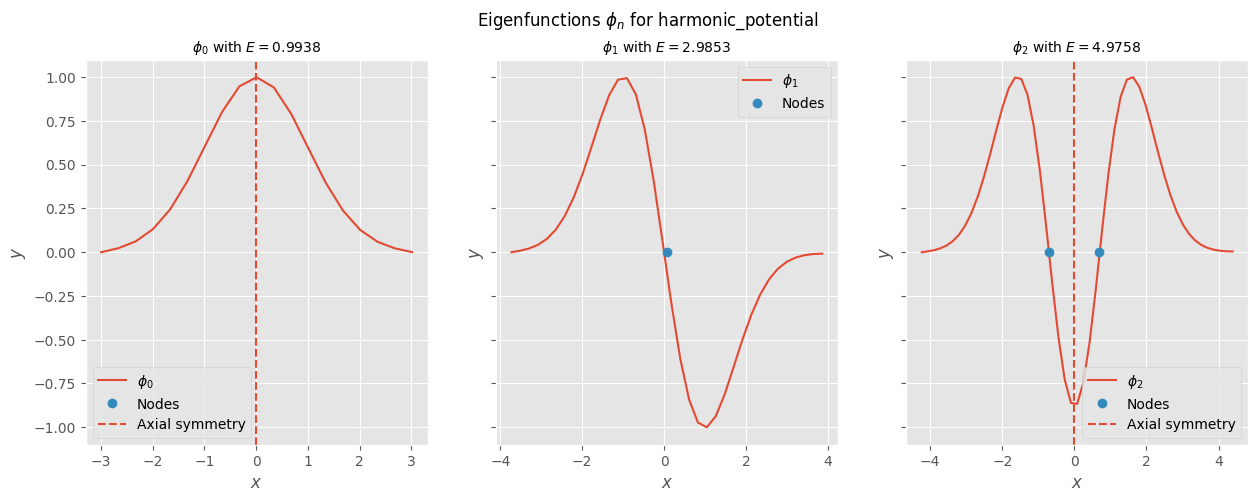

In [5]:
%matplotlib inline
def plot_eigenfunctions(figure, y0, y1, potential_function, energies, propagation_step: float = None, show_symmetry: bool = True, direction: str ="horizontal"):
    """_summary_

    Args:
        figure (_type_): _description_
        y0 (_type_): _description_
        y1 (_type_): _description_
        potential_function (_type_): _description_
        energies (_type_): _description_
        propagation_step (float, optional): _description_. Defaults to None.
        show_symmetry (bool, optional): _description_. Defaults to True.
        direction (str, optional): _description_. Defaults to "horizontal".
    """
    ax = figure.subplots(1, 3, sharey=True) if direction == "horizontal" else figure.subplots(3, 1, sharey=True)
    figure.suptitle(f"Eigenfunctions $\phi_n$ for {potential_function.__name__}")    

    for i in range(len(energies)):
        x, phi = auto_numerov(y0, y1, potential_function, energies[i], propagation_step)
        pseudo_normalization(phi)
        ax[i].plot(x, phi, label=f"$\phi_{i}$", c=red)
        ax[i].set_ylabel("$y$")
        ax[i].set_xlabel("$x$")
        ax[i].set_title(f"$\phi_{i}$ with $E={energies[i]:.4f}$", fontsize="medium")
        
        ax[i].plot(*search_nodes(phi, x), 'o', label="Nodes", c=blue)

        if i % 2 == 0 and show_symmetry:
            ax[i].axvline(0, label="Axial symmetry", linestyle="dashed", c=red)
        
        ax[i].legend()
        
        
        
E0: float = 0.9938
E1: float = 2.98526 
E2: float = 4.97576

y0 = 0
y1 = 10**(-3)

fig = plt.figure(figsize=(15, 5))
plot_eigenfunctions(fig, y0, y1, harmonic_potential, [E0, E1, E2], None)

plt.show()

Tout d'abord, les fonctions sont physiquements acceptables car on n'observe pas de divergence aux bords du domaine.

On observe alors plusieurs caractéristiques des fonctions propres $\phi_n$ pour un potentiel $V(x) = x^2$:
- Les fonctions $\phi_{2n}$ présentent un axe de symétrie $x=0$
- Les fonctions $\phi_{2n+1}$ présentent un centre d'inversion en $x=0$
- Le nombre de noeuds détermine le niveau d'énergie, ainsi $\phi_2$ présente 2 noeuds et $\phi_1$ en présente 1 seul.

Enfin, on peut remarquer que les écarts entre deux niveaux d'énergies où la fonction propre est physiquement acceptable sont séparés d'environ $2$.

On s'intéresse maintenant à vérifier la précision de notre méthode de calcul. Pour cela, nous allons comparer ```auto_numerov``` et ```numerov_method``` au solveur de scipy qu'on a implémenté dans ```scipy_odeint```. Nous chercherons à prendre le pas $h$ convergeant le plus rapidement vers le résultat de scipy, mais en conservant une précision acceptable.  

In [6]:
def plot_energy_levels(ax, x: np.ndarray, potential_function: Callable, energies: np.ndarray):
    V = potential_function(x)
    
    # To make a nice plot
    sieve = V < 1.1 * energies[-1]
    
    ax.plot(x[sieve], V[sieve], label=potential_function.__name__, c=red)
    
    for i in range(energies.shape[0]):
        ax.axhline(energies[i], c=green, linestyle="dashed")
        ax.text(0, energies[i], f"$E_{i} = {energies[i]:.4f}$", horizontalalignment='center', verticalalignment='bottom')
        
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.legend(loc="lower center")

def plot(fig, y0, y1, potential_function: Callable, propagation_steps: list[float] = [None], precision: float = 10**(-3), show_error: bool = True):
    gs = fig.add_gridspec(2, 4) if show_error else fig.add_gridspec(1, 4)
    
    energies = solve_eigenfunctions(y0, y1, potential_function, 0.1, precision, 3, propagation_steps[0])
    
    for i in range(3):
        energy = energies[i]
        eigen = fig.add_subplot(gs[0, i])
        error = fig.add_subplot(gs[1, i])
        
        eigen.set_title(f"$\phi_{i}, E_{i}={energy:.4f}$")
        
        error.set_title(f"Error on $\phi_{i}$")
        error.set_xlabel("$x$")
        
        if i == 0:
            eigen.set_ylabel("$y$")
            error.set_ylabel("Error")
        
        x_scipy, y_scipy = scipy_odeint(y0, y1, potential_function, energy)    
        
        eigen.plot(x_scipy, y_scipy, label="odeint", c="blue")
        for propagation_step in propagation_steps:
            x_auto, y_auto = auto_numerov(y0, y1, potential_function, energy, propagation_step)
            y_auto_interp = np.interp(x_scipy, x_auto, y_auto)
            
            propagation_error = np.abs(y_scipy - y_auto_interp)
            
            h = propagation_step if propagation_step != None else "Auto"
            eigen.plot(x_auto, y_auto, label=f"$h={h}$")
            error.plot(x_scipy, propagation_error, label=f"$h={h}$")

        eigen.legend()
        error.legend()
        
    energy_diagram = fig.add_subplot(gs[:,3])
    energy_diagram.set_title("Energy levels")
    plot_energy_levels(energy_diagram, x_scipy, potential_function, energies)

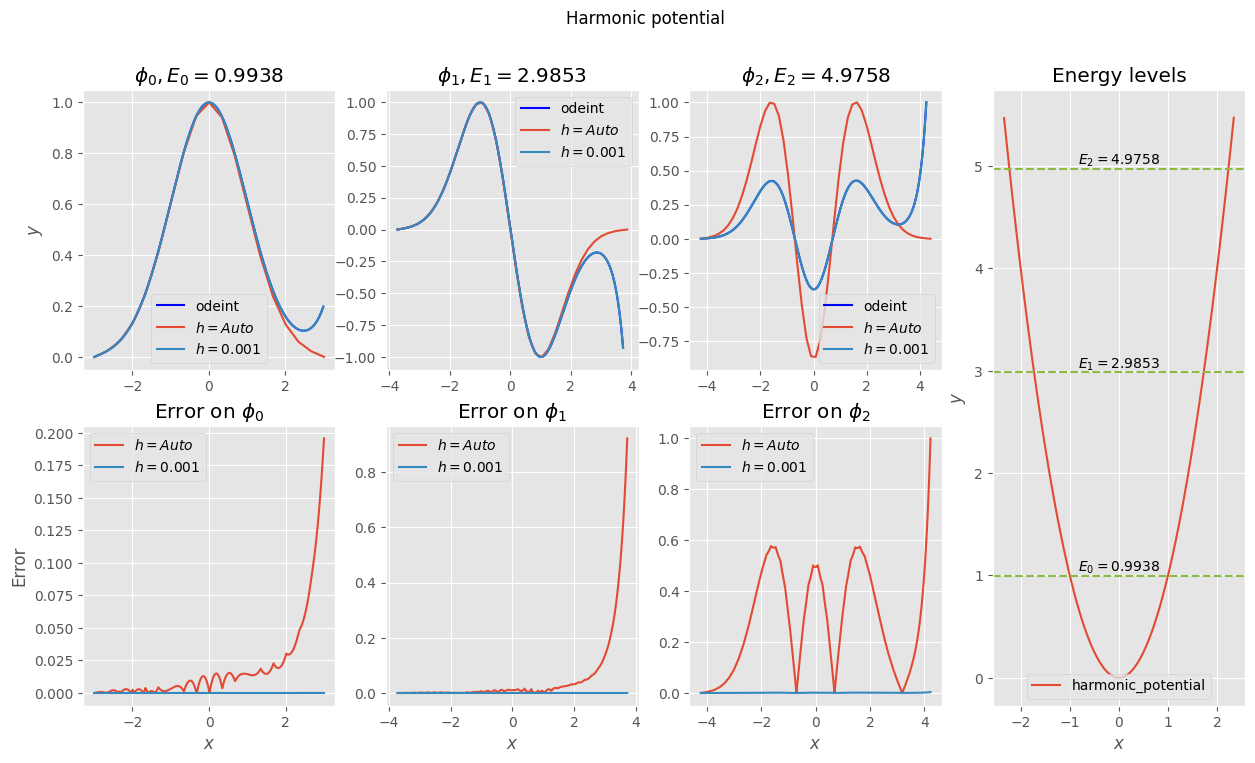

In [7]:
%matplotlib inline
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Harmonic potential")

plot(fig, 0, 10**(-3), harmonic_potential, [None, 10**(-3)])
plt.show()

On remarque rapidement que la méthode de Numerov en utilisant le pas $h$ décrit plus haut semble donner une fonction propre physiquement acceptable. Cependant, en résolvant l'équation avec un pas plus faible $h = 10^{-3}$ ainsi qu'avec ```scipy_odeint```, la solution ne converge finalement pas. En réalité, plus on utilise un $h$ petit, plus on convergera vers la solution exacte mais nous sommes limités en capacité de calcul, cela demanderait un temps de calcul bien trop conséquent.  

Avec de nombreux essais, nous avons trouvé que le pas $h$ ne change plus grand chose sur la valeur finale des niveaux d'énergies à partir d'un pas $h = 10^{-3}$ et que la méthode de Numerov est très proche de la solution proposée par ```scipy.odeint```.

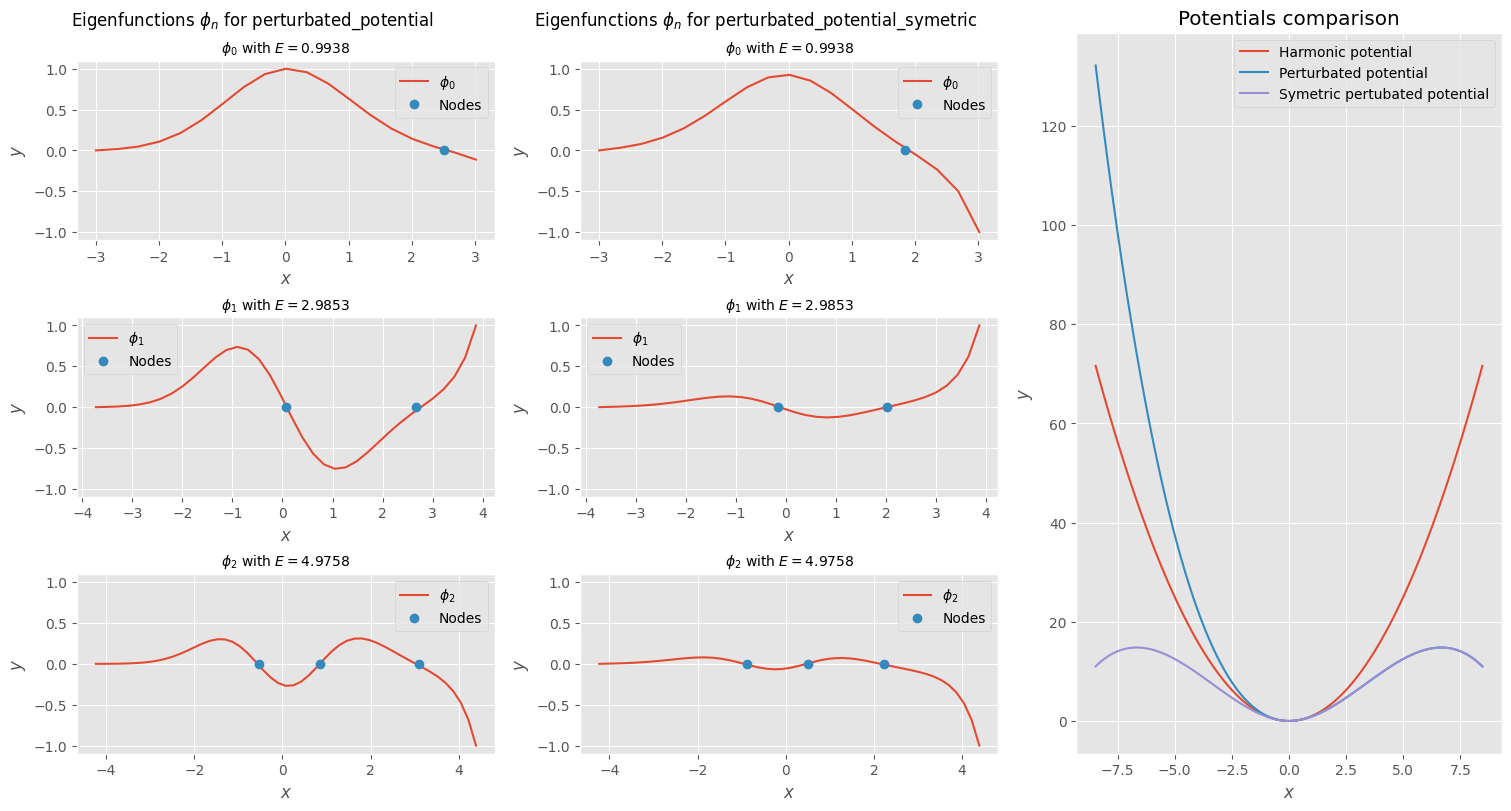

In [8]:
%matplotlib inline
y0 = 0
y1 = 10**(-3)

E = solve_eigenfunctions(y0, y1, harmonic_potential, 0.6, 10**(-3), 3, None)

fig = plt.figure(figsize=(15, 8), constrained_layout=True)
subfigs = fig.subfigures(1, 3)

plot_eigenfunctions(subfigs[0], y0, y1, perturbated_potential, E, show_symmetry=False, direction="vertical")
plot_eigenfunctions(subfigs[1], y0, y1, perturbated_potential_symetric, E, show_symmetry=False, direction="vertical")

ax = subfigs[2].subplots(1, 1)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Potentials comparison")

xi = np.sqrt([E[-1]]) + 2
x = np.linspace(-2*xi, 2*xi, 100)

ax.plot(x, harmonic_potential(x), label="Harmonic potential")
ax.plot(x, perturbated_potential(x), label="Perturbated potential")
ax.plot(x, perturbated_potential_symetric(x), label="Symetric pertubated potential")
ax.legend()

plt.show()

On remarque que pour le potentiel pertubé $V(x) = x^2 - 0.1x^3$, le potentiel conserve le même ordre de grandeur que pour le cas harmonique, mais légèrement dissymétrique. A l'inverse, pour le potentiel perturbé $V(x) = x^2 - 0.1|x|^3$, le potentiel conserve lui aussi le même ordre de grandeur que pour le cas harmonique, mais cette fois il est symétrique.

Les potentiels perturbés possèdent des régions où le potentiel tend vers $-\infty$, cependant, ces régions ne nous intéressent pas car on regarde uniquement la partie ayant une forme de "puit".

En reprenant les niveaux d'énergies du cas harmonique, les fonctions propres dans les nouveaux potentiels ne sont plus physiquement acceptable car elles divergent toutes. Nous utilisons donc notre fonction ```solve_eigenfunctions``` pour déterminer les nouveaux niveaux énergétiques dans ces potentiels. On récapitule l'ensemble de nos simulations dans le graphique suivant:

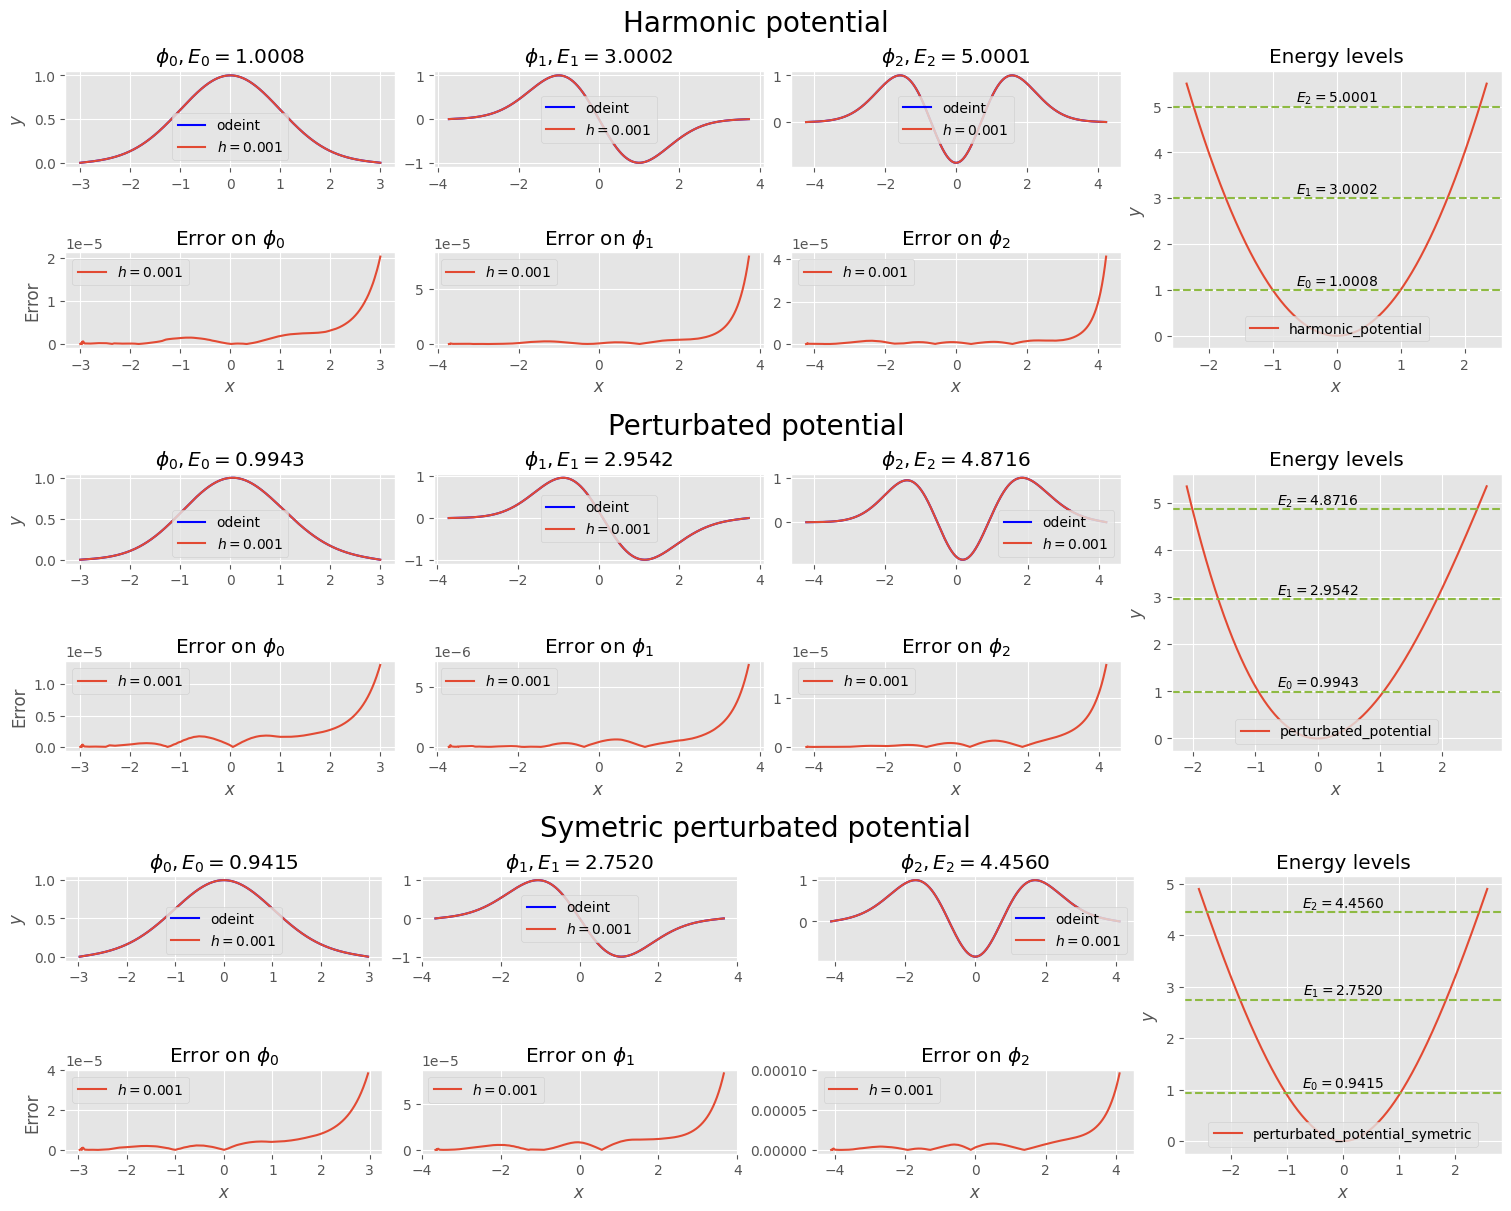

In [9]:
# This last cell can take more than 20 seconds to run, Matplotlib needs a lot of time to render this last figure with all propagations.
%matplotlib inline
fig = plt.figure(figsize=(15, 12), constrained_layout=True)
subfigs = fig.subfigures(3, 1)

subfigs[0].suptitle("Harmonic potential", fontsize="20")
subfigs[1].suptitle("Perturbated potential", fontsize="20")
subfigs[2].suptitle("Symetric perturbated potential", fontsize="20")

plot(subfigs[0], 0, 10**(-3), harmonic_potential, [10**(-3)])
plot(subfigs[1], 0, 10**(-3), perturbated_potential, [10**(-3)])
plot(subfigs[2], 0, 10**(-3), perturbated_potential_symetric, [10**(-3)])

Finalement, nous pouvons voir l'effet qu'à un puit de potential perturbé sur les niveaux d'énergies. On peut clairement voir que les potentiels perturbés abaissent simplement les niveaux d'énergies.

De plus, on remarque que les fonctions propres restent de la même forme et que l'erreur de notre implémentation de la méthode de Numerov est satisfaisante avec des erreurs maximales de $10^{-4}$ (sur les valeurs normalisées).

On cherche à visualiser l'effet de la perturbation du potentiel sur les niveaux d'énergies avec une animation. On doit utiliser le paramètre "%matplotlib notebook" pour pouvoir visualiser une animation directement dans un notebook. On doit néanmoins ajouter "%matplotlib inline" dans les autres cellules de notre notebook pour pouvoir afficher des images.

In [13]:
import matplotlib.animation as animation
from IPython.display import HTML

#Change the parameter of the notebook to see the dynamic animation
%matplotlib notebook 

fig2, ax2 =plt.subplots()
t=0 #The parameter which fixes the potential

# A fonction which vary each frame
def potential_frame(x_anim):
    return x_anim**2-0.01*t*np.abs(x_anim**3)

#Variable asymetric potential 
def potential_frame_as(x_anim):
    return x_anim**2-0.01*t*x_anim**3

#Draw energy lines for t=0
E_anim = solve_eigenfunctions(0, 10**(-3), potential_frame, 0.6, 10**(-3), 5, None)
E1_line=ax2.axhline(E_anim[0], c=green, linestyle="dashed")
E1_text=ax2.text(0, E_anim[0], f"$E_{0} = {E_anim[0]:.5f}$", horizontalalignment='center', verticalalignment='bottom')
E2_line=ax2.axhline(E_anim[1], c=green, linestyle="dashed")
E2_text=ax2.text(0, E_anim[1], f"$E_{1} = {E_anim[1]:.5f}$", horizontalalignment='center', verticalalignment='bottom')
E3_line=ax2.axhline(E_anim[2], c=green, linestyle="dashed")
E3_text=ax2.text(0, E_anim[2], f"$E_{2} = {E_anim[2]:.5f}$", horizontalalignment='center', verticalalignment='bottom')

x_anim=np.linspace(-2.8,2.8,200)
t_text=ax2.text(0.02,0.95,'',transform=ax2.transAxes)
plot_anim=ax2.plot(x_anim,potential_frame(x_anim))[0]
ax2.set_ylabel('')
ax2.set_xlabel('x')


frames=66 #Number of frames of our animation

#Fonction to draw the animation
def ani(frame: float):
    global t,E1_line,E1_text,E2_line,E2_text,E3_line,E3_text,frames
    #Change the global parameter to change the potential, in a way to make a reflected animation
    if frame <= frames/4 :
        t=frame
    elif frame <=frames/2 and frame>frames/4 :
        t= frames/2 - frame
    elif frame <3*frames/4 and frame>frames/2 :
        t=frame - frames/2
    else: 
        t=frames - frame

    if frame<=frames/2 :
        plot_anim.set_ydata(potential_frame(x_anim))
        t_text.set_text(f'V=x**2-{0.01*t}*abs(x**3)')
        E_anim = solve_eigenfunctions(0, 10**(-3), potential_frame, 0.6, 10**(-3), 5, None)
    if frame>=frames/2 :
        plot_anim.set_ydata(potential_frame_as(x_anim))
        t_text.set_text(f'V=x**2-{0.01*t}*x**3')
        E_anim = solve_eigenfunctions(0, 10**(-3), potential_frame_as, 0.6, 10**(-3), 5, None)
    #Remove energy lines to avoid superposition
    E1_line.remove()
    E1_text.remove()
    E2_line.remove()
    E2_text.remove()
    E3_line.remove()
    E3_text.remove()

    #Compute and draw news energy levels
    
    E1_line=ax2.axhline(E_anim[0], c=green, linestyle="dashed")
    E1_text=ax2.text(0, E_anim[0], f"$E_{0} = {E_anim[0]:.5f}$", horizontalalignment='center', verticalalignment='bottom')
    E2_line=ax2.axhline(E_anim[1], c=green, linestyle="dashed")
    E2_text=ax2.text(0, E_anim[1], f"$E_{1} = {E_anim[1]:.5f}$", horizontalalignment='center', verticalalignment='bottom')
    E3_line=ax2.axhline(E_anim[2], c=green, linestyle="dashed")
    E3_text=ax2.text(0, E_anim[2], f"$E_{2} = {E_anim[2]:.5f}$", horizontalalignment='center', verticalalignment='bottom')
    return plot_anim,t_text,

#Draw the animation
anim=animation.FuncAnimation(fig=fig2,func=ani,frames=frames,interval=100)
#anim.save('potentiel2.gif', fps=10)
plt.show()
HTML(anim.to_jshtml())

<IPython.core.display.Javascript object>

MovieWriter ffmpeg unavailable; using Pillow instead.
